# Quickly analyze gridded files and make plots

### note: works *only* on srvx2 with geopandas



In [1]:
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import os,sys
import os
import json
import xarray as xr
import numpy as np
import shapely
from shapely.geometry import Point, Polygon
import numpy 
import matplotlib.animation as animation

import geopandas as gpd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm

from multiprocessing import Pool
from functools  import partial

import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Loading WMO regions 

In [2]:
def loading_WMO_regions_gpd():
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO


## Running 



In [3]:
out_dir = 'Plots_notebook/'
os.system('mkdir  ' + out_dir )
all_stat_conf = pd.read_csv('all_merged_station_configurations.csv', delimiter = '\t')
db = '/raid60/scratch/federico/GRIDDED_FILES_28NOV_10'


## Cusstom Colorbar

In [4]:
def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
        """Return a LinearSegmentedColormap
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
        and in the interval (0,1).
        """
        se = [(None,) * 3, 0.0]
        for s in seq:
            se.append(s[0])
            se.append(s[1])#+ list(seq) +
            seq=se+[ (None,) * 3]
            cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
        return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
                 "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
                 "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
                 "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
                 "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
                 "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
                 "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
                 "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
                 "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))
                 
CM = make_colormap(rgblist2)

In [5]:
## Function for plotting

In [6]:
def make_plot_gpd(WMO, sc, database , press, size, date):

#def make_plot_gpd(WMO, sc = '', database = '', date = '', what = 'a', press = 85000, size = 10 ):
    # https://stackoverflow.com/questions/59417997/how-to-plot-a-list-of-shapely-points                                                                                                                                                                                                   

    date_s = date
    date = np.datetime64(date)
    

    """ Loading from geopandas built-in methods """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #world = gpd.read_file('Europe_coastline.shp')
    #world = world.query( 'continent == "Europe"' )
    w = world.plot()
    WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)

    """ Saving coordinates to plot, and values """
    points_lat, points_lon, anomaly, average = [] , [] , [] , []
    lat_stations, lon_stations = [],[]
    none_lat, none_lon = [],[]
    
    """ Loop over files in database """
    db = os.listdir(database)    
    for f in tqdm(db):
        if 'dat' in f:
            no_lat, no_lon = f.split('_')[3] ,  f.split('_')[4]
            none_lat.append(float(no_lat))
            none_lon.append(float(no_lon))
            continue
        
        else:
            #loaded = xr.open_dataset(database + '/' + f).to_dataframe()
            #df_red = loaded.loc [ (loaded['date_time'] == date) & (loaded['z_coordinate'] == press ) 
            loaded = xr.open_dataset(database + '/' + f)
            stations = loaded['longitude'].attrs
            stat = stations['stations']
            if stat == 'None':
                pass
            else:
                for id in stat.split('_'):
                    ID = str(np.bytes_(id))
                    station = sc.loc [ sc['primary_id']== ID ]
                    try:
    
                        la = station['latitude'].values[0]
                        lo = station['longitude'].values[0]
                        if lo > 180:
                            lo = -360 + lo
                        
                        lat_stations.append(la)
                        lon_stations.append(lo)
                    except:
                        pass
                    
            loaded = loaded.to_dataframe()
            df_red = loaded.loc [ (loaded['date_time'] == date) & (loaded['z_coordinate'] == press ) ]
            
            points_lat.append(df_red['latitude'].values[0])
            points_lon.append(df_red['longitude'].values[0])
            an , an_bias = df_red['anomaly'].values[0], df_red['anomaly_bias'].values[0]
            av , av_bias = df_red['average'].values[0], df_red['average_bias'].values[0]

            if not np.isnan(av_bias):
                average  .append(av_bias)
            else:
                average  .append(av)     
                    
            if not np.isnan(an_bias):
                anomaly  .append(an_bias)
            else:
                anomaly.append(an)
            
        #print(points_lon, points_lat, anomaly, average)
   
    if size == 10:
        marker_size = 75
    elif size == 5:
        marker_size = 17
        
    what = 'anomaly'   
    if what == 'anomaly':
        w = world.plot()
        WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)        
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])        
        plt.scatter( lon_stations, lat_stations , c='lime',  s = 0.8, marker = 'o' )
        #plt.scatter( none_lon, none_lat , c= 'lightgray' , s = marker_size, marker = 'x' )
        plt.scatter( points_lon, points_lat , c= anomaly,  s = marker_size, marker = 's', cmap='bwr', alpha = 0.8, 
                     edgecolor = 'black' , linewidths=0.3 )

        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
        cbar.set_label('Temperature Anomaly over 20 years [K]')
        plt.clim(-5, 5)

        plt.title ('Climate Studies using Radiosonde Data - ' + date_s + ', p=' +  str(press)[:-2] + ' [hPa] ' , fontsize = 8)
        plt.show()
        plt.savefig(out_dir + '/ClimateChange_' + date_s + '_' + what + '_' + '_plevel_' + str(press) + '_gridsize_' + str(size) + '.png', dpi= 150,   bbox_inches = 'tight' )
        plt.close()
        print('Done +++' , date , ' ' , what )
        
        
    what = 'average'        
    
    if what == 'average':
        w = world.plot()
        WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)        
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])        
        plt.scatter( lon_stations, lat_stations , c='lime',  s = 1, marker = 'o')
        plt.scatter( points_lon, points_lat , c= average,  s = marker_size, marker = 's', cmap= CM , alpha = 0.8,
                     edgecolor = 'black' , linewidths=0.3)
        
        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
        cbar.set_label('Average Temperature [K]')
        plt.clim(200, 330)


        plt.title ('Climate Studies using Radiosonde Data - ' + date_s + ', p=' +  str(press)[:-2] + ' [hPa] ' , fontsize = 9)
        plt.show()
        plt.savefig(out_dir + '/ClimateChange_' + date_s + '_' + what + '_' + '_plevel_' + str(press) + '_gridsize_' + str(size) + '.png', dpi= 150,   bbox_inches = 'tight' )
        plt.close()
        
        
        print('Done +++' , date , ' ' , what )

In [7]:

## Opening the file
### Files are plain netCDF files, with no groups
### File names are constructed with lat_lon_size i.e. latitude, longitude of the cenre of the grid box, and size of the box 


loaded = xr.open_dataset(db + '/22_20_lat_lon_size_35.0_15.0_10.0_averages.nc')
                         
stations = loaded['longitude'].attrs

print('Available stations in the box: \n' )
for s in stations['stations'].split('_'):
    print(s)
      
df = loaded.to_dataframe()
df[30000:30020]
                         
                         
                         

Available stations in the box: 

0-20000-0-62010
0-20000-0-62011
0-20000-0-16420
0-20000-0-16597
0-20000-0-16596
0-20000-0-62019
0-20000-0-60715
0-20000-0-33123
0-20000-0-16429


,z_coordinate,date_time,average,anomaly,average_bias,anomaly_bias,latitude,longitude,grid_size
index,,,,,,,,,
30000,1000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30001,2000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30002,3000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30003,5000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30004,7000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30005,10000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30006,15000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30007,20000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0
30008,25000,1983-02-15 12:00:00,NaN,NaN,NaN,NaN,35.0,15.0,10.0


## Running plot with pool

100%|██████████| 1296/1296 [00:36<00:00, 35.68it/s] 



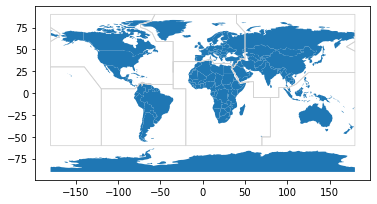

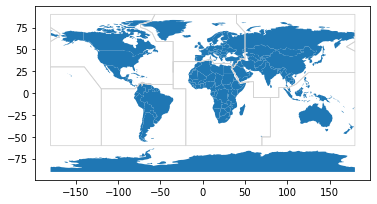

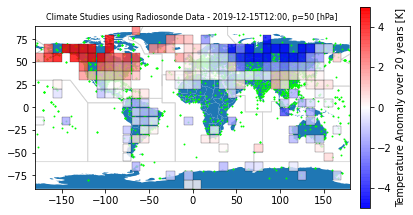

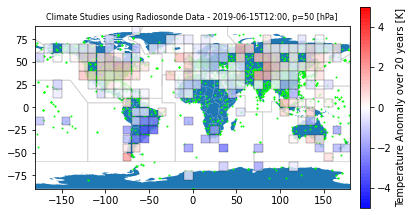

Done +++ 2019-12-15T12:00   anomaly
Done +++ 2019-06-15T12:00   anomaly


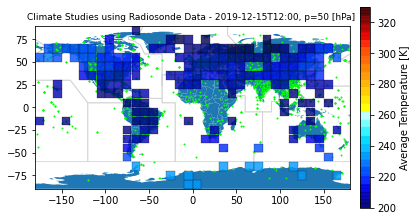

Done +++ 2019-12-15T12:00   average


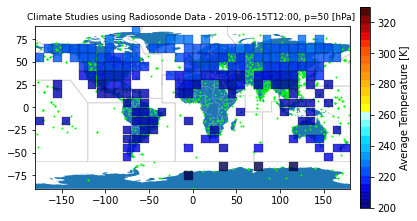

Done +++ 2019-06-15T12:00   average


100%|██████████| 5184/5184 [01:16<00:00, 67.79it/s]  



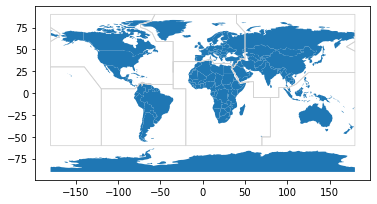

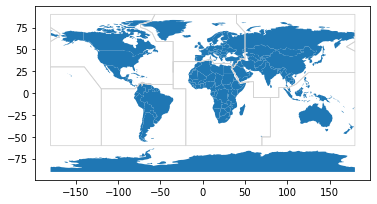

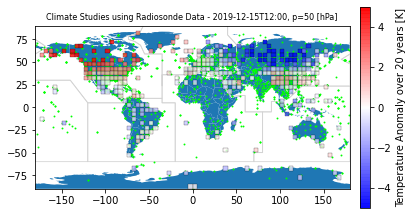

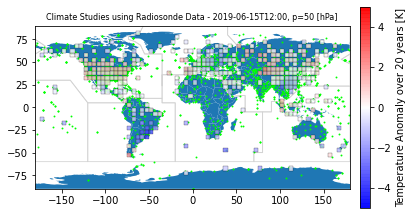

Done +++ 2019-12-15T12:00   anomaly
Done +++ 2019-06-15T12:00   anomaly


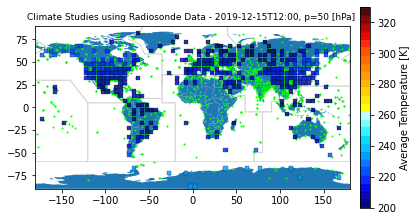

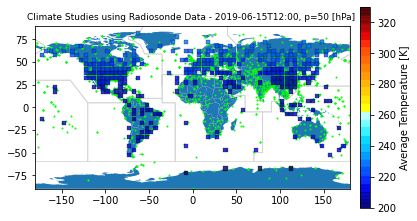

Done +++ 2019-12-15T12:00   average
Done +++ 2019-06-15T12:00   average


100%|██████████| 1296/1296 [00:08<00:00, 145.70it/s]


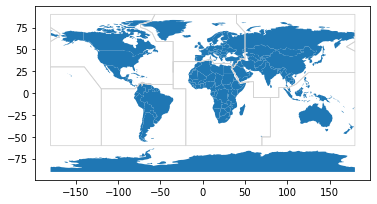

100%|██████████| 1296/1296 [00:09<00:00, 141.93it/s]


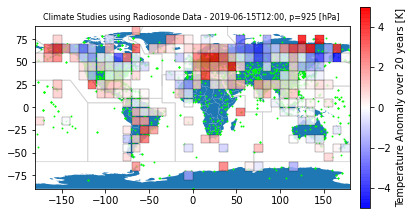

Done +++ 2019-06-15T12:00   anomaly


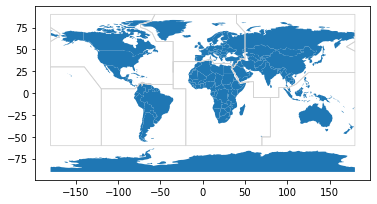

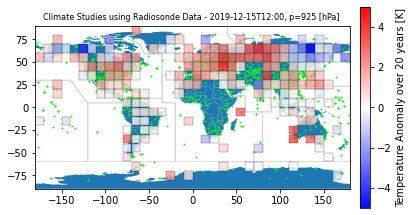

Done +++ 2019-12-15T12:00   anomaly


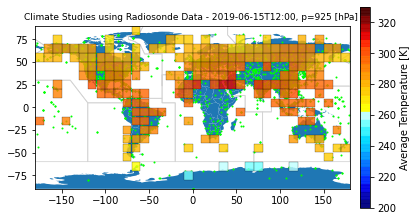

Done +++ 2019-06-15T12:00   average


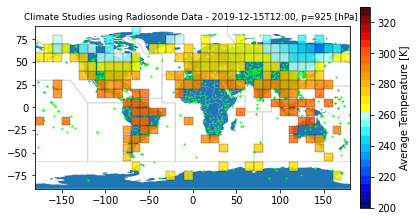

Done +++ 2019-12-15T12:00   average


  0%|          | 0/5184 [00:00<?, ?it/s]

In [ ]:
WMO =  loading_WMO_regions_gpd()


days = [ '2019-06-15T12:00' , '2019-12-15T12:00' ]



#std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
plevels = [ 5000, 92500 ]


out_dir = 'Plots_notebook/'
os.system('mkdir  ' + out_dir )
all_stat_conf = pd.read_csv('all_merged_station_configurations.csv', delimiter = '\t')

db_10 = '/raid60/scratch/federico/GRIDDED_FILES_28NOV_10'
db_5   = '/raid60/scratch/federico/GRIDDED_FILES_28NOV_5'


p = Pool(40)


# try single day 
#a = make_plot_gpd (WMO, all_stat_conf , db_10 , 85000, 10, days[0]) 

for press in plevels:
        func = partial(make_plot_gpd, WMO, all_stat_conf , db_10 , press, 10)      
        out = p.map(func, days) 
        func = partial(make_plot_gpd, WMO, all_stat_conf , db_5 , press , 5)             
        out = p.map(func, days) 